In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
from tqdm import tqdm

from graspy.embed import JointRDPG
from graspy.plot import heatmap
from graspy.utils import is_symmetric, symmetrize
from graspy.cluster import GaussianCluster, KMeansCluster
from graspy.simulations import sbm

from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.mgc.mgc import MGC

from simulations import sbm_marg_corr_diff, ER_corr
from utils import sbm_params, triu_no_diag, to_distance_mtx, identity, power, non_diagonal, \
    estimate_block_assignment, block_permute, sort_graph
from plot import plot_pvalue_ecdf

In [2]:
A = np.arange(1, 10).reshape(3, 3)
A

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [3]:
def rho_sbm_diff_block(rho, k, AL, BL, n=100):
    if sum(k) != n:
        raise ValueError('the total number of vertices in each community should equal n')
    
    if np.any(AL == 0) or np.any(AL == 1) \
            or np.any(BL == 0) or np.any(BL == 1):
        raise ValueError('block probabilities AL and BL cannot have 0 or 1')

    largest_rho = np.minimum(np.sqrt(AL*(1-BL)/((1-AL)*BL)), np.sqrt((1-AL)*BL/(AL*(1-BL))))
    if np.any(rho > largest_rho):
        raise ValueError('the largest valid rho for the specified AL and BL is {}. Please specify a rho that is smaller than the largest valid rho.'.format(
            np.amin(largest_rho)))

    AL = symmetrize(AL)
    BL = symmetrize(BL)
    A = sbm(k, AL)

    AL_new = np.zeros_like(A)
    BL_new = np.zeros_like(A)
    block_indices = np.insert(np.cumsum(np.array(k)), 0, 0)
    for i in range(AL.shape[0]):
        for j in range(AL.shape[1]):
            AL_new[block_indices[i]:block_indices[i+1], block_indices[j]:block_indices[j+1]] = AL[i, j]
            BL_new[block_indices[i]:block_indices[i+1], block_indices[j]:block_indices[j+1]] = BL[i, j]

    prob = BL_new + A*rho*np.sqrt((1-AL_new)*BL_new*(1-BL_new)/AL_new) - (1-A)*rho*np.sqrt(AL_new*BL_new*(1-BL_new)/(1-AL_new))
    B = np.random.binomial(1, prob)
    B = B.astype(np.float64)
    B = symmetrize(B)
    np.fill_diagonal(B, 0)
    return A, B

In [4]:
A, B = rho_sbm_diff_block(0.3, k=[70, 30], AL=sbm_params(a=0.7, b=0.3), BL=sbm_params(a=0.7, b=0.3), n=100)

In [13]:
block_assignment = estimate_block_assignment(A, B)

In [14]:
block_assignment

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [16]:
A_sorted = sort_graph(A, block_assignment)

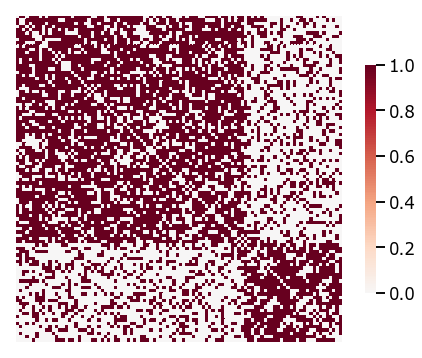

In [17]:
heatmap(A, figsize=(8, 6))

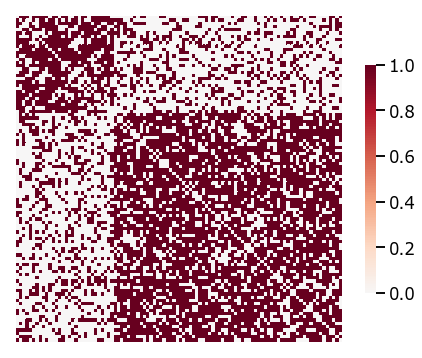

In [18]:
heatmap(A_sorted, figsize=(8, 6))

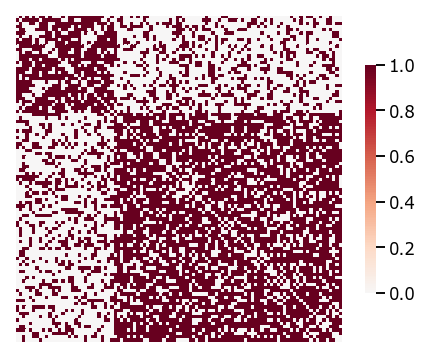

In [19]:
heatmap(block_permute(A_sorted, np.sort(block_assignment)), figsize=(8, 6))

In [8]:
def rho_sbm_power(indept_test, transform_func, rho, P1, P2, k, n, mc=500, alpha=0.05):
    test_stat_null_array = np.zeros(mc)
    test_stat_alt_array = np.zeros(mc)
    for i in range(mc):
        A, B = rho_sbm_diff_block(rho, k, P1, P2, n)
        test_stat_alt, _ = indept_test.test_statistic(
            matrix_X=transform_func(A), matrix_Y=transform_func(B))
        test_stat_alt_array[i] = test_stat_alt

        # generate the null by permutation
        block_assignment = estimate_block_assignment(A, B)
        B_sorted = sort_graph(B, block_assignment)
        A_null = block_permute(A, block_assignment)
        test_stat_null, _ = indept_test.test_statistic(
            matrix_X=transform_func(A_null), matrix_Y=transform_func(B_sorted))
        test_stat_null_array[i] = test_stat_null
    # if pearson, use the absolute value of test statistic then use one-sided
    # rejection region
    if indept_test.get_name() == 'pearson':
        test_stat_null_array = np.absolute(test_stat_null_array)
        test_stat_alt_array = np.absolute(test_stat_alt_array)
    critical_value = np.sort(test_stat_null_array)[math.ceil((1-alpha)*mc)]
    power = np.where(test_stat_alt_array > critical_value)[0].shape[0] / mc
    return power

In [ ]:
%%time
n_arr = np.array([10, 50, 100, 200, 500]) # np.linspace(10, 100, 10, dtype=int)
rho_arr = np.array([0]) #np.array([0, 0.1])
P1 = sbm_params(a=0.7, b=0.3)
P2 = sbm_params(a=0.2, b=0.5)
test_names = ['pearson', 'dcorr'] #['pearson', 'dcorr'] , 'mgc']
power_sbm = {
    'pearson': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'dcorr': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'mgc': np.zeros((rho_arr.shape[0], n_arr.shape[0]))
}

for name in test_names:
    for i, rho in enumerate(rho_arr):
        for j, n in enumerate(n_arr):
            k = [int(0.7*n), n-int(0.7*n)]
            if name == 'pearson':
                test = RVCorr(which_test='pearson')
                test_power = rho_sbm_power(test, triu_no_diag, rho=rho, P1=P1, P2=P2, k=k, n=n)
            elif name == 'dcorr':
                test = DCorr(compute_distance_matrix=identity)
                test_power = rho_sbm_power(test, to_distance_mtx, rho=rho, P1=P1, P2=P2, k=k, n=n)
            elif name == 'mgc':
                test = MGC(compute_distance_matrix=identity)
                test_power = rho_sbm_power(test, to_distance_mtx, rho=rho, P1=P1, P2=P2, k=k, n=n)
            power_sbm[name][i, j] = test_power
            print('finish {} for rho={}, n={}'.format(name, rho, n))

finish pearson for rho=0, n=10
finish pearson for rho=0, n=50
finish pearson for rho=0, n=100


In [ ]:
power_sbm

In [23]:
with open('../data/rho_sbm_diff_block_power.pkl', 'rb') as f:
    power_results = pickle.load(f)

In [19]:
n_arr = np.linspace(10, 100, 10, dtype=int)
mpl.style.use('seaborn')

plt.figure(figsize=(8, 6))
colors = {
    'mgc': 'red',
    'dcorr': 'blue', 
    'pearson': 'orange'
}

<Figure size 576x432 with 0 Axes>

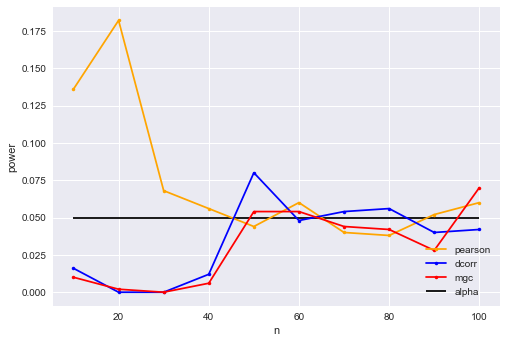

In [24]:
rho = 0
for name, test_power in power_results.items():
        plt.plot(n_arr, test_power[0, :], color=colors[name], linestyle='-', marker='.', label='{}'.format(name))

plt.hlines(y=0.05, xmin=np.amin(n_arr), xmax=np.amax(n_arr), label='alpha')
plt.legend(loc=4)
plt.xlabel('n')
plt.ylabel('power')
plt.savefig('../figures/sbm_diff_block_power_null.png', bbox_inches='tight')

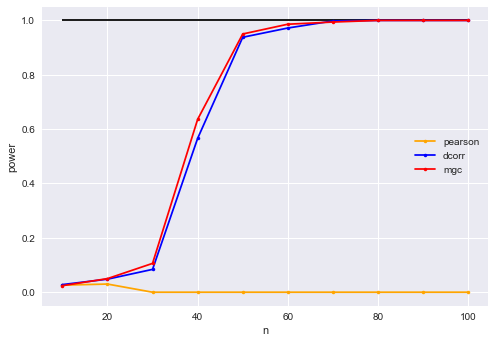

In [25]:
rho = 0.1
for name, test_power in power_results.items():
        plt.plot(n_arr, test_power[1, :], color=colors[name], linestyle='-', marker='.', label='{}'.format(name))

plt.hlines(y=1, xmin=np.amin(n_arr), xmax=np.amax(n_arr))
plt.legend(loc=7)
plt.xlabel('n')
plt.ylabel('power')
plt.savefig('../figures/sbm_diff_block_power_alt.png'.format(rho), bbox_inches='tight')

In [5]:
def pvalue(A, B, indept_test, transform_func, k=10, null_mc=500, block_est_repeats=1):
    test_stat_alternative, _ = indept_test.test_statistic(
        matrix_X=transform_func(A), matrix_Y=transform_func(B))

    block_assignment = estimate_block_assignment(A, B, k=k, num_repeats=block_est_repeats)
    B_sorted = sort_graph(B, block_assignment)

    test_stat_null_array = np.zeros(null_mc)
    for j in range(null_mc):
        # A_null is the permuted matrix after being sorted by block assignment
        A_null = block_permute(A, block_assignment)
        test_stat_null, _ = indept_test.test_statistic(
            matrix_X=transform_func(A_null), matrix_Y=transform_func(B_sorted))
        test_stat_null_array[j] = test_stat_null

    p_value = np.where(test_stat_null_array > test_stat_alternative)[
        0].shape[0] / test_stat_null_array.shape[0]
    return p_value

In [6]:
n = 50
k = [35, 15]
P1 = sbm_params(a=0.7, b=0.3)
P2 = sbm_params(a=0.2, b=0.5)
#test = MGC(compute_distance_matrix=identity)
test = DCorr(compute_distance_matrix=identity)
A, B = rho_sbm_diff_block(0.0, k, P1, P2, n)
pvalue_dist = np.zeros(100)
for i in tqdm(range(100)):
    pvalue_dist[i] = pvalue(A, B, test, to_distance_mtx)

100%|██████████| 100/100 [04:43<00:00,  2.54s/it]


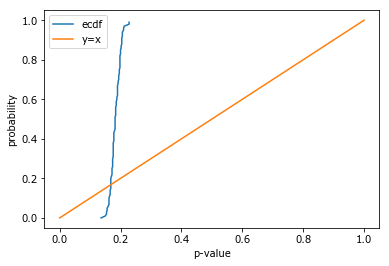

In [7]:
plot_pvalue_ecdf(pvalue_dist, title='')